In [3]:
from micromind import Metric
from micromind.utils.parse import parse_arguments

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
import random
import importlib
import numpy as np

from tqdm import tqdm

batch_size = 64

In [2]:
from micromind import MicroMind
from micromind.networks import PhiNet

import torch
import torch.nn as nn

model_path = "../pretrained/finetuned/baseline.ckpt"

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
elif torch.backends.mps.is_available: 
    device = torch.device("mps")
    print("Running on the MPS")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class ImageClassification(MicroMind):

    # test 1 with n as input vector size and m classes custom d
    # n has to be calculated from the output of the neural network of the feature extractor
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.input = 344
        self.output = 100

        self.modules["feature_extractor"] = PhiNet(
            input_shape=(3, 224, 224),
            alpha=0.9,
            num_layers=7,
            beta=0.5,
            t_zero=4.0,
            include_top=False,
            num_classes=1000,
            compatibility=False,
            divisor=8,
            downsampling_layers=[4,5,7]
        )

        # Taking away the classifier from pretrained model
        pretrained_dict = torch.load(model_path, map_location=device)
        model_dict = {}
        for k, v in pretrained_dict.items():
            if "classifier" not in k:
                model_dict[k] = v

        #loading the new model
        self.modules["feature_extractor"].load_state_dict(pretrained_dict["feature_extractor"])        
        for _, param in self.modules["feature_extractor"].named_parameters():    
            param.requires_grad = False

        self.modules["classifier"] = nn.Sequential(                
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()            
        )    

    def forward(self, batch):        
        x = self.modules["feature_extractor"](batch)    
        x = self.modules["classifier"](x)    
        return x

    def compute_loss(self, pred, batch):
        return nn.CrossEntropyLoss()(pred, batch[1])                   
        

Running on the GPU


In [3]:
train_transform = transforms.Compose(
        [
         transforms.ToTensor(), 
         transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343), (0.26733428587941854, 0.25643846292120615, 0.2761504713263903)), 
         transforms.Resize((160, 160), antialias=True), 
         transforms.RandomHorizontalFlip(0.5),
         transforms.RandomRotation(10)
        ] 
    )

trainset = torchvision.datasets.CIFAR100(
    root="../data/cifar-100", train=True, download=True, transform=train_transform
)

train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,    
)

Files already downloaded and verified


In [4]:
model = ImageClassification()

In [5]:
# creating tensors 
x = torch.tensor([]) 
y = torch.tensor([]) 
  
# printing above created tensors 
print("Tensor x:", x) 
print("Tensor y:", y) 
  
# join above tensor using "torch.stack()" 
print("join tensors:") 
t = torch.stack((x,y)) 
print(t)

Tensor x: tensor([])
Tensor y: tensor([])
join tensors:
tensor([], size=(2, 0))


In [6]:
it = iter(train_loader)

batch = next(it)

x = model(batch[0])
y = batch[1]

for j in range(500):    
    batch = next(it)

    output = model(batch[0])
    labels = batch[1]    

    x = torch.cat((x, output))
    y = torch.cat((y, labels))    


In [21]:
import pickle

# with open('embeddings_.pkl', 'wb') as file:
#     pickle.dump({"outputs":x, "labels":y}, file)    

In [22]:
with open('embeddings.pkl', 'rb') as file:
    data = pickle.load(file)

x = data["outputs"]
y = data["labels"]

In [23]:
print(x.shape)
print(y.shape)

torch.Size([32064, 344])
torch.Size([32064])


In [24]:
embeddings = np.array(x)

In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def kmeans_cosine(data, k, max_iter=100):
    # Normalize data
    data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)
    
    # Initialize centroids
    centroids = data_normalized[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iter):
        # Compute cosine similarity and assign clusters
        similarity = cosine_similarity(data_normalized, centroids)
        clusters = np.argmax(similarity, axis=1)
        
        # Update centroids
        new_centroids = np.array([data_normalized[clusters == i].mean(axis=0) for i in range(k)])
        
        # Normalize new centroids
        new_centroids = new_centroids / np.linalg.norm(new_centroids, axis=1, keepdims=True)
        
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return clusters, centroids

clusters, centroids = kmeans_cosine(embeddings, 10, max_iter=20)

print(clusters.shape)
print(centroids.shape)

(32064,)
(10, 344)


In [8]:
# mapping tra le 100 classi qui e le altre 100 classi di la
y

tensor([69, 83,  2,  ..., 15, 72, 75])

# Some checks

(array([323., 339., 326., 317., 326., 321., 329., 334., 315., 324., 314.,
        319., 316., 327., 312., 315., 325., 331., 325., 314., 321., 327.,
        339., 321., 328., 330., 302., 317., 329., 318., 312., 300., 306.,
        344., 323., 321., 330., 318., 313., 338., 321., 317., 330., 312.,
        325., 308., 305., 296., 313., 318., 311., 314., 334., 320., 315.,
        337., 307., 326., 326., 338., 315., 325., 322., 314., 310., 317.,
        340., 307., 316., 320., 331., 309., 313., 312., 333., 338., 323.,
        297., 322., 303., 330., 314., 322., 314., 330., 317., 334., 316.,
        330., 309., 320., 328., 324., 317., 334., 317., 328., 298., 320.,
        333.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.75, 25.74,
        26.73, 27.72, 28.71, 29.7 , 30.69, 31.68, 32.67, 33.66, 34.65,
        35.64, 36.63, 37.62, 38.61

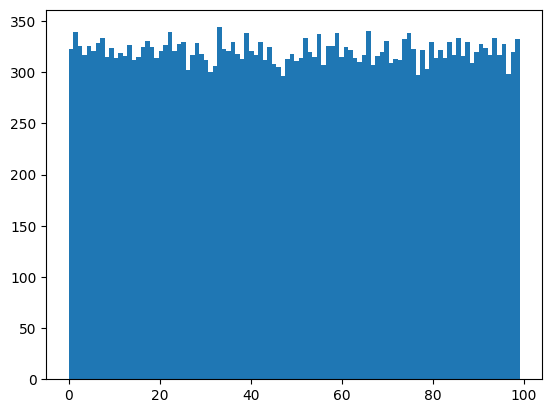

In [9]:
import matplotlib.pyplot as plt
plt.hist(y, bins=100)

In [10]:
len(torch.unique(y))

100

In [11]:
torch.unique(y)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

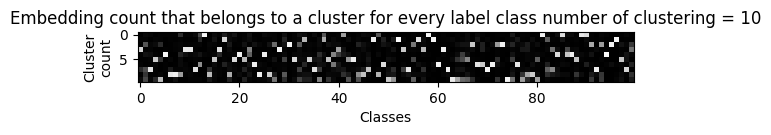

In [26]:
#fpr every label in 1 to 100 we want to see how many go to 

# matrix 10 x 100 -> for every row we see where how many labels from x target go to that cluster

a = np.zeros((centroids.shape[0],100))

#print(a)

for i, cluster in enumerate(clusters):
    a[cluster][y[i]] += 1

plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")
plt.title("Embedding count that belongs to a cluster for every label class number of clustering = " + str(centroids.shape[0]))
plt.imshow(a,cmap='Greys_r')



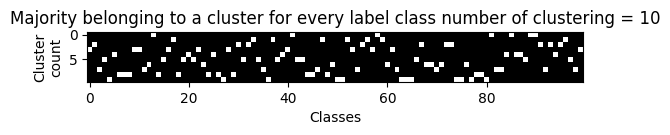

In [27]:
## majority voting for each class
b = np.argmax(a, axis=0)

c = np.zeros((centroids.shape[0],100))
for x in range(100):    
    c[b[x]][x] = 1

plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")
plt.title("Majority belonging to a cluster for every label class number of clustering = " + str(centroids.shape[0]))
plt.imshow(c, cmap='Greys_r')

In [28]:
# use the second matrix as a mask 

false_negative = np.ma.array(a,mask=c)

TypeError: 'module' object is not callable

In [14]:
print(c)

[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.

In [17]:
# map each line to cluster: label to cluster belonging

maps = {}

for i, x in enumerate(c):
    for j, y in enumerate(x):
        if(y==1):
            maps[j] = i
    
print(maps)

{0: 0, 1: 0, 53: 0, 54: 0, 57: 0, 62: 0, 70: 0, 82: 0, 83: 0, 92: 0, 4: 1, 27: 1, 29: 1, 32: 1, 44: 1, 50: 1, 51: 1, 63: 1, 64: 1, 74: 1, 75: 1, 77: 1, 78: 1, 80: 1, 2: 2, 5: 2, 11: 2, 20: 2, 25: 2, 35: 2, 36: 2, 39: 2, 46: 2, 84: 2, 86: 2, 87: 2, 94: 2, 98: 2, 3: 3, 15: 3, 19: 3, 21: 3, 31: 3, 34: 3, 38: 3, 42: 3, 43: 3, 65: 3, 66: 3, 88: 3, 97: 3, 6: 4, 7: 4, 14: 4, 18: 4, 24: 4, 26: 4, 45: 4, 79: 4, 30: 5, 55: 5, 67: 5, 72: 5, 73: 5, 91: 5, 93: 5, 95: 5, 9: 6, 10: 6, 16: 6, 22: 6, 23: 6, 28: 6, 40: 6, 60: 6, 61: 6, 69: 6, 71: 6, 99: 6, 12: 7, 17: 7, 37: 7, 49: 7, 68: 7, 76: 7, 90: 7, 8: 8, 13: 8, 41: 8, 48: 8, 58: 8, 81: 8, 85: 8, 89: 8, 33: 9, 47: 9, 52: 9, 56: 9, 59: 9, 96: 9}


In [28]:
np.sum(c, axis=1)

array([ 8.,  7.,  9.,  7., 19.,  8.,  6., 18.,  6., 12.])